## SVM

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Loading Data
data = pd.read_csv("final_validated_data.csv")
data.head()

,Unnamed: 0,RowID,maxsal,minsal,intern_num,month_num,day,industry,city,scale,...,招聘,媒体,内容,专员,产品,销售,开发,工程师,助理,运营
0,0,0,100,50,62,3,5,互联网/游戏/软件,北京,2000人以上,...,0,1,0,0,0,0,0,0,0,0
1,1,1,150,100,5,4,5,教育/培训,深圳,15-50人,...,0,0,0,0,0,0,0,0,0,0
2,2,2,300,250,8,4,5,互联网/游戏/软件,上海,15-50人,...,0,0,0,0,0,0,0,0,0,0
3,3,3,100,100,3,4,4,教育/培训,上海,15-50人,...,0,0,0,0,0,0,0,0,0,0
4,4,4,150,100,176,3,4,互联网/游戏/软件,广州,2000人以上,...,0,0,0,0,1,0,0,0,0,1


### Cleaning Data and Labeling

(array([1180.,    0.,    0., 1622.,    0.,    0., 1170.,    0.,    0.,
        1026.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

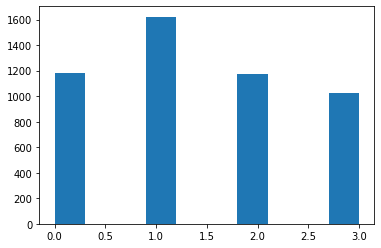

In [2]:

IT_df = data.drop(['Unnamed: 0', 'RowID', 'maxsal', 'minsal','industry', 'city', 'scale', 'name', 'uuid', 'c_desc', 'c_tag','c_name'],axis=1)

# #确定 X和 y

X = IT_df

# Label the max salary (4 classes)
label = []
max_sal = data["maxsal"].to_numpy()
for i in max_sal:

    if i in range(0,150):
        label.append(0)
    elif i in range(150,175):
        label.append(1)
    elif i in range(175,250):
        label.append(2)
    else:
        label.append(3)
y = np.array(label)
plt.hist(y)

### Scaling and Spliting

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import svm

# Divide into train, validate, and test set
# X_final_test and y_final_test are our test set, we will not touch it 
# X_test and y_test are out validation set. 

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_final_test_scaled = scaler.transform(X_final_test) 


In [7]:
# Baseline
print(1622/len(y))

0.32452981192476993


### Running SVM

In [9]:
clf = svm.SVC(decision_function_shape = 'ovo', kernel = 'rbf')
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

# print('===================================')

kernel = rbf
train accuracy: 0.5455808782657031
test accuracy: 0.44555555555555554


### Grid Search and Cross Validation

In [10]:
# GridSearch

from sklearn.model_selection import GridSearchCV
import sklearn.metrics

parameters = {

    'C': [x for x in [0.01,0.1,1,10,100,1000]],
    'gamma': [x for x in [0.5,5,50,500]]
}

grid_search = GridSearchCV(svm.SVC(), param_grid = parameters, scoring = 'accuracy', cv=5, return_train_score = True)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

# gamma 应该大一些，sigma小(1/sigma^2)，来提高精度，那个图形更尖更集中。
# 1/C C越大，regularization越弱。

{'C': 100, 'gamma': 0.5}


In [68]:
# GridSearch

from sklearn.model_selection import GridSearchCV
import sklearn.metrics

parameters = {

    'C': [x for x in [0.01,0.1,1,10,100,1000]],
    'gamma': [x for x in [0.5,5,50,500]]
}

grid_search = GridSearchCV(svm.SVC(probability=True), param_grid = parameters, scoring = 'neg_log_loss', cv=5, return_train_score = True)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)

# gamma 应该大一些，sigma小(1/sigma^2)，来提高精度，那个图形更尖更集中。
# 1/C C越大，regularization越弱。

{'C': 1, 'gamma': 0.5}


### Validation

In [47]:
model = svm.SVC(decision_function_shape = 'ovo', kernel = 'rbf', C = 1, gamma = 0.5, probability = True)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print(accuracy_score(y_pred,y_train))
print(accuracy_score(y_pred_test,y_test))

0.6097832128960534
0.4477777777777778


In [48]:
from sklearn.metrics import accuracy_score, precision_score, log_loss

train_loss = log_loss(y_train,model.predict_proba(X_train_scaled))
test_loss = log_loss(y_test,model.predict_proba(X_test_scaled))

print(train_loss)
print(test_loss)

1.0521097649433913
1.2155815199320752


Done
[0.6097832128960534, 0.7323513062812673, 0.7565314063368538, 0.7682045580878266, 0.7773763201778766, 0.7823790994997221, 0.7846025569760978, 0.7879377431906615, 0.7909949972206781, 0.7940522512506948, 0.7946081156197887]
[0.4477777777777778, 0.44555555555555554, 0.44666666666666666, 0.4477777777777778, 0.44555555555555554, 0.44222222222222224, 0.43666666666666665, 0.44, 0.44222222222222224, 0.44555555555555554, 0.4444444444444444]


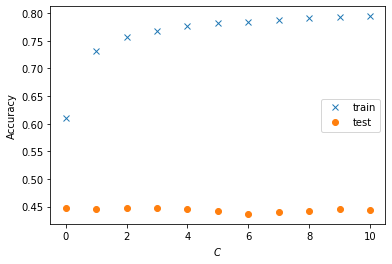

In [54]:
train_acc = []
test_acc = []

for i in [1,10,20,30,40,50,60,70,80,90,100]:
    clf = svm.SVC(decision_function_shape = 'ovo', kernel = 'rbf', C = i, gamma = 0.5)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    acc_test = (accuracy_score(y_pred,y_test))
    test_acc.append(acc_test)
    
    y_pred = clf.predict(X_train_scaled)
    acc_train = (accuracy_score(y_pred,y_train))
    train_acc.append(acc_train)
    
#     print('C: {}'.format(i))
#     print('train accuracy: {}'.format(acc_train))
#     print('test accuracy: {}'.format(acc_test))
print('Done')

print(train_acc)
print(test_acc)

plt.plot(train_acc,'x',label="train");
plt.plot(test_acc,'o',label="test");
plt.xlabel('$C$'); plt.ylabel('Accuracy')
plt.legend();